# SPX-VIX Joint Calibration - Structured Replication Workflow

This notebook uses a phased workflow to replicate the paper `Joint Modelling and Calibration of SPX and VIX by Optimal Transport`.

**Workflow Design:**

1.  **Setup & Parameters**: Configure the environment and define two parameter sets: one for "Quick Validation" and one for "Full Replication". A switch `RUN_FULL_SCALE` selects which workflow to execute.
2.  **Data Generation**: Generate market data using the JAX/GPU accelerated Monte Carlo simulation.
3.  **Quick Validation**: If `RUN_FULL_SCALE` is `False`, this section runs a mini-scale (e.g., 40x40 grid) end-to-end calibration. **The goal is to verify the correctness of the entire code pipeline in minutes.**
4.  **Full Scale Replication**: If `RUN_FULL_SCALE` is `True`, this section runs the complete calibration process with parameters consistent with the paper. **Warning: This step is expected to take several hours.**

**GPU Acceleration:** This notebook relies on the implemented JAX/GPU accelerated modules (`simulate_heston`, `pricing_pde`, `hjb_solver`).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
PROJECT_ROOT = '/content/drive/MyDrive/project/ot_spx_vix' # Please change to your project's root directory

In [3]:
# === PART 1: ENVIRONMENT SETUP & PARAMETERS ===
import os
import sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import time

# --- Main Control Switch ---
# Set to False for a quick validation run (mini-scale).
# Set to True for the final, long-running replication (full-scale).
RUN_FULL_SCALE = False


# --- Add 'src' directory to Python path ---
SRC_PATH = os.path.join(PROJECT_ROOT, 'src')
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

# --- Import all custom modules ---
# NOTE: If you edit .py files, you MUST restart the runtime for changes to take effect.
from utils import CalibrationParams, NumericalParams, Grid, get_payoff_functions, black_scholes_vega
from simulate_heston import generate_and_save_market_data
from reference_iter import get_initial_beta_bar, smooth_beta_star
from optimizer import run_optimization
from pricing_pde import solve_pricing_pde_jax
from visualize import plot_volatility_skews, plot_calibrated_paths

print("\nAll modules imported successfully.")

# --- Define Parameter Sets ---
params = CalibrationParams()

# Parameters for Full Scale Replication
num_params_full = NumericalParams(
    NX1=100, NX2=100, NT=int(params.T_DAYS * 2), OPT_TOL_INNER=1e-4, POLICY_ITER_MAX=40
)

# Parameters for Quick Validation (Mini-Scale)
num_params_debug = NumericalParams(
    NX1=40, NX2=40, NT=int(params.T_DAYS), OUTER_ITERATIONS=2,
    OPT_TOL_INNER=1e-2, POLICY_ITER_MAX=30
)

# --- Select Active Parameter Set ---
if RUN_FULL_SCALE:
    num_params = num_params_full
    print("*** CONFIGURATION: FULL REPLICATION MODE ***")
else:
    num_params = num_params_debug
    print("*** CONFIGURATION: QUICK VALIDATION MODE (MINI-SCALE) ***")


All modules imported successfully.
*** CONFIGURATION: QUICK VALIDATION MODE (MINI-SCALE) ***


---

## 2. Data Generation

This step generates the target market prices using the JAX/GPU accelerated simulation if the data file doesn't exist. This should be very fast.

In [4]:
# === PART 2: DATA GENERATION ===
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)
market_data_path = 'data/simulated_market_data_gpu.csv'

if not os.path.exists(market_data_path):
    print(f"Market data file not found. Generating using JAX/GPU...")
    generate_and_save_market_data(params, seed=42, save_path=market_data_path)
else:
    print(f"Loading existing market data from '{market_data_path}'.")

market_data_df = pd.read_csv(market_data_path)
market_prices = pd.Series(market_data_df.Price.values, index=market_data_df.Instrument).to_dict()
print("\nMarket data loaded successfully.")

Market data file not found. Generating using JAX/GPU...
--- Generating 'Market' Data using Heston MC (JAX/GPU) ---
Simulating 250000 paths on GPU...
Data generation complete.
Market data saved to data/simulated_market_data_gpu.csv

Market data loaded successfully.


In [5]:
# --- Set X2_0_T dynamically to match the target VIX future price ---
from dataclasses import replace

# 读取市场上的 VIX future 价格（单位大约是 29 左右）
vix_future_market_price = market_prices[f'VIX_FUTURE_{params.T0_DAYS}D']

# 用公式反推 X2_0_T ： 0.5 * ((VIX/100)^2) * (T - T0)
new_X2_0_T = 0.5 * ((vix_future_market_price / 100)**2) * (params.T - params.T0)

# 更新 params
params = replace(params, X2_0_T=new_X2_0_T)

print(f"Updated X2_0_T = {params.X2_0_T:.6f}")


Updated X2_0_T = 0.003526


---

## 3. Quick Validation Run

This cell runs **only if `RUN_FULL_SCALE` is False**. It executes a fast, small-scale calibration to verify the entire code pipeline.


          Starting Quick Validation Run

Debug grid and initial parameters created.
Calculating Vegas for scaling...
✓ Vegas and scaled market prices calculated.

--- Debug Outer Iteration 1/2 ---
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...
✓ Final alpha* and beta* calculated.
Smoothing beta_star to create the next beta_bar...

--- Debug Outer Iteration 2/2 ---
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...
✓ Final alpha* and beta* calculated.

Debug calibration loop finished.

Calculating final model prices for debug run...

Debug Calibration Results:


,Instrument,Market Price,Model Price,Difference
0,SINGULAR_CONTRACT_79D,0.000000,1.301662e-05,0.000013
1,SPX_CALL_44D_K100,4.125446,5.838297e-03,-4.119608
2,SPX_CALL_44D_K105,2.091311,5.068340e-13,-2.091311
3,SPX_CALL_44D_K110,0.910898,9.642679e-22,-0.910898
4,SPX_CALL_44D_K115,0.338408,6.014423e-34,-0.338408
5,SPX_CALL_44D_K85,15.358239,1.450736e+01,-0.850879
6,SPX_CALL_44D_K90,10.937004,9.507359e+00,-1.429646
7,SPX_CALL_44D_K95,7.109706,4.507359e+00,-2.602347
8,SPX_CALL_79D_K100,5.489499,1.034716e+00,-4.454783
9,SPX_CALL_79D_K105,3.332824,6.653012e-02,-3.266294



Generating debug plots...
Volatility skew plot saved to results/volatility_skews_debug.png


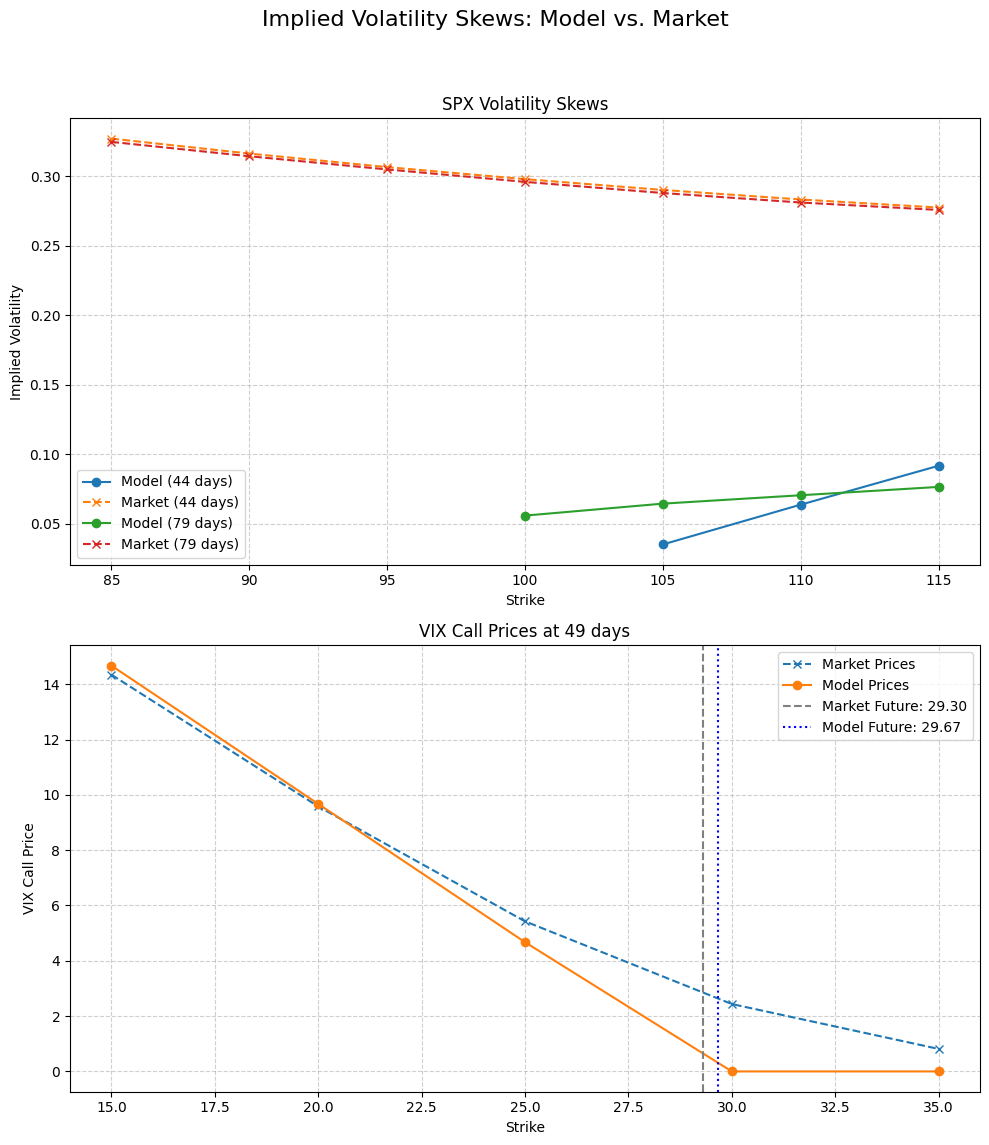

Path simulation plot saved to results/calibrated_paths_debug.png


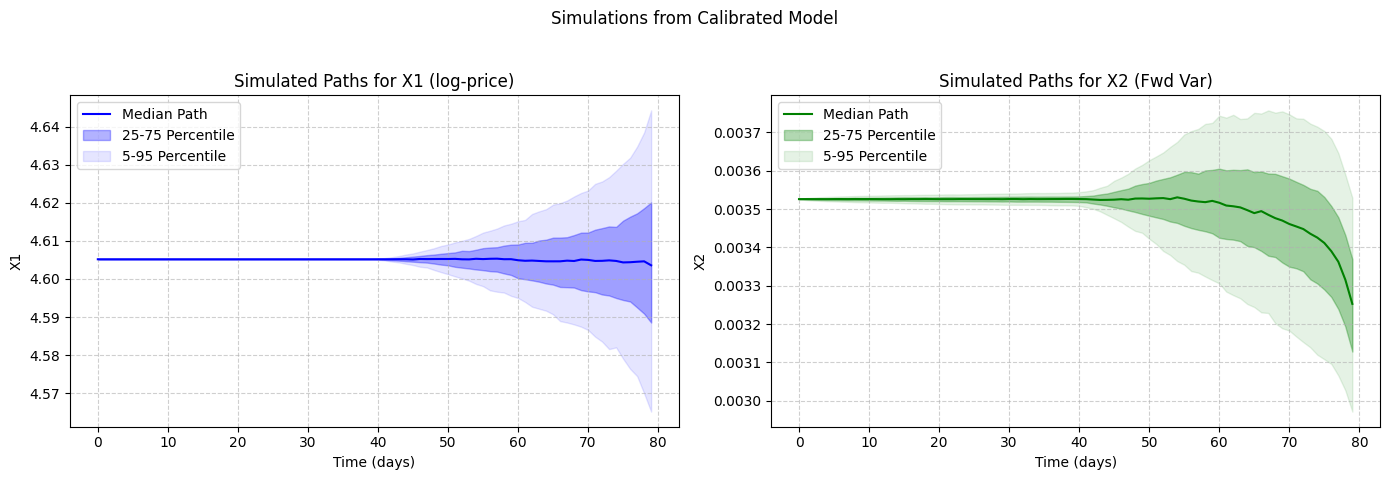


          Quick Validation Complete! Total Time: 63.92 seconds


In [6]:
# === PART 3: QUICK VALIDATION (MINI-SCALE) ===

if not RUN_FULL_SCALE:
    start_time_debug = time.time()
    print("\n" + "="*60)
    print("          Starting Quick Validation Run")
    print("="*60 + "\n")

    # --- Initialization ---\
    grid = Grid(num_params_debug, params)
    _, instrument_names = get_payoff_functions(grid, params)
    beta_bar_t = get_initial_beta_bar(grid, params, ref_type='Heston')
    lambdas_flat = np.zeros(len(instrument_names))
    print("Debug grid and initial parameters created.")

    # --- [!! NEW !!] Calculate Vegas and Scaled Prices ---
    print("Calculating Vegas for scaling...")
    vegas_dict = {}
    scaled_market_prices = {}

    # 简单的参考波动率估算 (可以根据需要调整)
    ref_vol_spx = 0.30
    ref_vol_vix = 0.80 # VIX 的波动率通常更高
    vix_spot_approx = market_prices.get(f'VIX_FUTURE_{params.T0_DAYS}D', 29.0) # 使用期货价格作为 VIX "spot"

    for name in instrument_names:
        if name.startswith('SPX_CALL_'):
            K = float(name.split('_K')[-1])
            T = params.T_SPX1 if f'_{params.T_SPX1_DAYS}D' in name else params.T
            vega = black_scholes_vega(params.S0, K, T, params.R, ref_vol_spx)
        elif name.startswith('VIX_CALL_'):
            K = float(name.split('_K')[-1])
            T = params.T - params.T0 # VIX期权到期日在T0，标的(远期方差)到期日在T
            vega = black_scholes_vega(vix_spot_approx, K, T, params.R, ref_vol_vix)
        else:
            # 对于 VIX Future 和 Singular Contract, 使用缩放因子 1.0
            vega = 1.0

        # 避免除以零或非常小的值
        if vega < 1e-6:
            vega = 1.0

        vegas_dict[name] = vega
        scaled_market_prices[name] = market_prices.get(name, 0.0) / vega

    print("✓ Vegas and scaled market prices calculated.")
    # ----------------------------------------------------

    # --- Calibration Loop (Updated Call) ---
    for outer_iter in range(num_params_debug.OUTER_ITERATIONS):
        print(f"\n--- Debug Outer Iteration {outer_iter + 1}/{num_params_debug.OUTER_ITERATIONS} ---")

        # [!! MODIFIED CALL !!] - 传递 9 个参数
        opt_result, alpha_star_t, beta_star_t = run_optimization(
            grid, params, num_params_debug, instrument_names,
            market_prices,          # 1. 原始市场价格 (用于 optimizer 内部) - (注：其实 optimizer.py 没用它，但为清晰保留)
            scaled_market_prices,   # 2. 缩放后的市场价格
            vegas_dict,             # 3. Vega 字典
            beta_bar_t,             # 4. 原始 beta_bar_t
            lambdas_flat            # 5. 原始 lambdas_flat
        )

        lambdas_flat = opt_result.x
        if outer_iter < num_params_debug.OUTER_ITERATIONS - 1:
             beta_bar_t = smooth_beta_star(beta_star_t, num_params_debug)

    final_alpha_t, final_beta_t = alpha_star_t, beta_star_t
    print("\nDebug calibration loop finished.")

    # --- Evaluation and Visualization (Updated) ---
    print("\nCalculating final model prices for debug run...")
    payoffs, _ = get_payoff_functions(grid, params)
    final_alpha_t_jax = jnp.array(final_alpha_t)
    final_beta_t_jax = jnp.array(final_beta_t)

    # [!! NEW !!] 创建缩放后的 Payoff JAX 数组
    scaled_payoffs_list = []
    for name in instrument_names:
        vega = vegas_dict.get(name, 1.0)
        scaled_payoffs_list.append(jnp.array(payoffs[name]) / vega)
    all_scaled_payoffs_jax = jnp.stack(scaled_payoffs_list, axis=0)

    ix1_0, ix2_0 = grid.get_initial_indices(params.X1_0, params.X2_0_T)

    maturity_indices = jnp.array([
        grid.time_idx_map['T_SPX1'] if f'SPX_CALL_{params.T_SPX1_DAYS}D' in name
        else grid.time_idx_map['T'] if (f'SPX_CALL_{params.T_DAYS}D' in name or 'SINGULAR' in name)
        else grid.time_idx_map['T0']
        for name in instrument_names
    ], dtype=jnp.int32)

    dx1_jax = jnp.array(grid.dx1, dtype=jnp.float32)
    dx2_jax = jnp.array(grid.dx2, dtype=jnp.float32)
    dt_jax = jnp.array(grid.dt, dtype=jnp.float32)
    nx1 = grid.Np.NX1
    nx2 = grid.Np.NX2

    def price_single_instrument(scaled_payoff, maturity_idx):
        return solve_pricing_pde_jax(
            scaled_payoff, params, num_params_debug, # 使用缩放后的 payoff
            dx1_jax, dx2_jax, dt_jax, nx1, nx2,
            final_alpha_t_jax, final_beta_t_jax,
            jnp.array(0, dtype=jnp.int32), maturity_idx
        )

    vmapped_pricer = jax.vmap(price_single_instrument, in_axes=(0, 0))
    all_scaled_price_surfaces = vmapped_pricer(all_scaled_payoffs_jax, maturity_indices).block_until_ready() # 得到缩放后的价格曲面

    final_scaled_model_prices = np.array(all_scaled_price_surfaces[:, ix1_0, ix2_0])

    # [!! MODIFIED !!] - 反向缩放模型价格以进行比较
    calibrated_prices = {}
    for i, name in enumerate(instrument_names):
        scaled_model_price = final_scaled_model_prices[i]
        vega = vegas_dict.get(name, 1.0) # 使用之前计算的 Vega
        original_scale_model_price = scaled_model_price * vega
        calibrated_prices[name] = original_scale_model_price

    results_df = pd.DataFrame([{\
        'Instrument': name,\
        'Market Price': market_prices.get(name, 0),\
        'Model Price': p,\
        'Difference': p - market_prices.get(name, 0)\
    } for name, p in calibrated_prices.items()])
    results_df = results_df.set_index('Instrument').loc[list(instrument_names)].reset_index()

    print("\nDebug Calibration Results:")
    display(results_df)
    results_df.to_csv('results/calibration_results_debug.csv', index=False)

    print("\nGenerating debug plots...")
    # 绘图函数使用原始价格
    plot_volatility_skews(calibrated_prices, market_prices, params, save_path='results/volatility_skews_debug.png')
    plot_calibrated_paths(grid, final_alpha_t, final_beta_t, params, save_path='results/calibrated_paths_debug.png')

    end_time_debug = time.time()
    print("\n" + "="*60)
    print(f"          Quick Validation Complete! Total Time: {end_time_debug - start_time_debug:.2f} seconds")
    print("="*60)
else:
    print("Skipping Quick Validation (RUN_FULL_SCALE is set to True).")

---

In [8]:
print("min =", price_surface.min(), "max =", price_surface.max(), "mean =", price_surface.mean())


NameError: name 'price_surface' is not defined

## 4. Full Scale Replication Run

This cell runs **only if `RUN_FULL_SCALE` is True**. It executes the complete, time-consuming calibration.


          Starting Full Scale Replication Run

Full scale grid and initial parameters created.
Grid size: 100 x 100 x 158
Number of instruments: 21
Calculating Vegas for scaling...
✓ Vegas and scaled market prices calculated.



Full Scale Calibration:   0%|          | 0/5 [00:00<?]

Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...


Full Scale Calibration:  20%|██        | 1/5 [07:21<29:26]

✓ Final alpha* and beta* calculated.
Smoothing beta_star to create the next beta_bar...
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...


Full Scale Calibration:  40%|████      | 2/5 [14:45<22:08]

✓ Final alpha* and beta* calculated.
Smoothing beta_star to create the next beta_bar...
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...


Full Scale Calibration:  60%|██████    | 3/5 [22:03<14:41]

✓ Final alpha* and beta* calculated.
Smoothing beta_star to create the next beta_bar...
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...


Full Scale Calibration:  80%|████████  | 4/5 [29:22<07:19]

✓ Final alpha* and beta* calculated.
Smoothing beta_star to create the next beta_bar...
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...


Full Scale Calibration: 100%|██████████| 5/5 [36:36<00:00]

✓ Final alpha* and beta* calculated.

✓ Full scale calibration loop finished.

Calculating final model prices for full scale run...
Pricing all instruments in parallel...


✓ Pricing complete.

Full Scale Calibration Results:


/tmp/ipython-input-13306614.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  'Rel. Error %': 100 * (p - market_prices.get(name, 0)) / market_prices.get(name, 1e-10)\


,Instrument,Market Price,Model Price,Difference,Rel. Error %
0,SINGULAR_CONTRACT_79D,0.000000,1.261439e-05,0.000013,inf
1,SPX_CALL_44D_K100,4.125446,1.434550e-01,-3.981991,-96.522678
2,SPX_CALL_44D_K105,2.091312,3.246156e-21,-2.091312,-100.000000
3,SPX_CALL_44D_K110,0.910899,1.172302e-41,-0.910899,-100.000000
4,SPX_CALL_44D_K115,0.338409,0.000000e+00,-0.338409,-100.000000
5,SPX_CALL_44D_K85,15.358240,1.513065e+01,-0.227592,-1.481891
6,SPX_CALL_44D_K90,10.937004,1.013065e+01,-0.806351,-7.372691
7,SPX_CALL_44D_K95,7.109707,5.130650e+00,-1.979056,-27.835977
8,SPX_CALL_79D_K100,5.489500,1.441080e+00,-4.048419,-73.748425
9,SPX_CALL_79D_K105,3.332825,1.370475e-01,-3.195778,-95.887948


✓ Results saved to results/calibration_results_full.csv

Generating full scale plots...
Volatility skew plot saved to results/volatility_skews_full.png


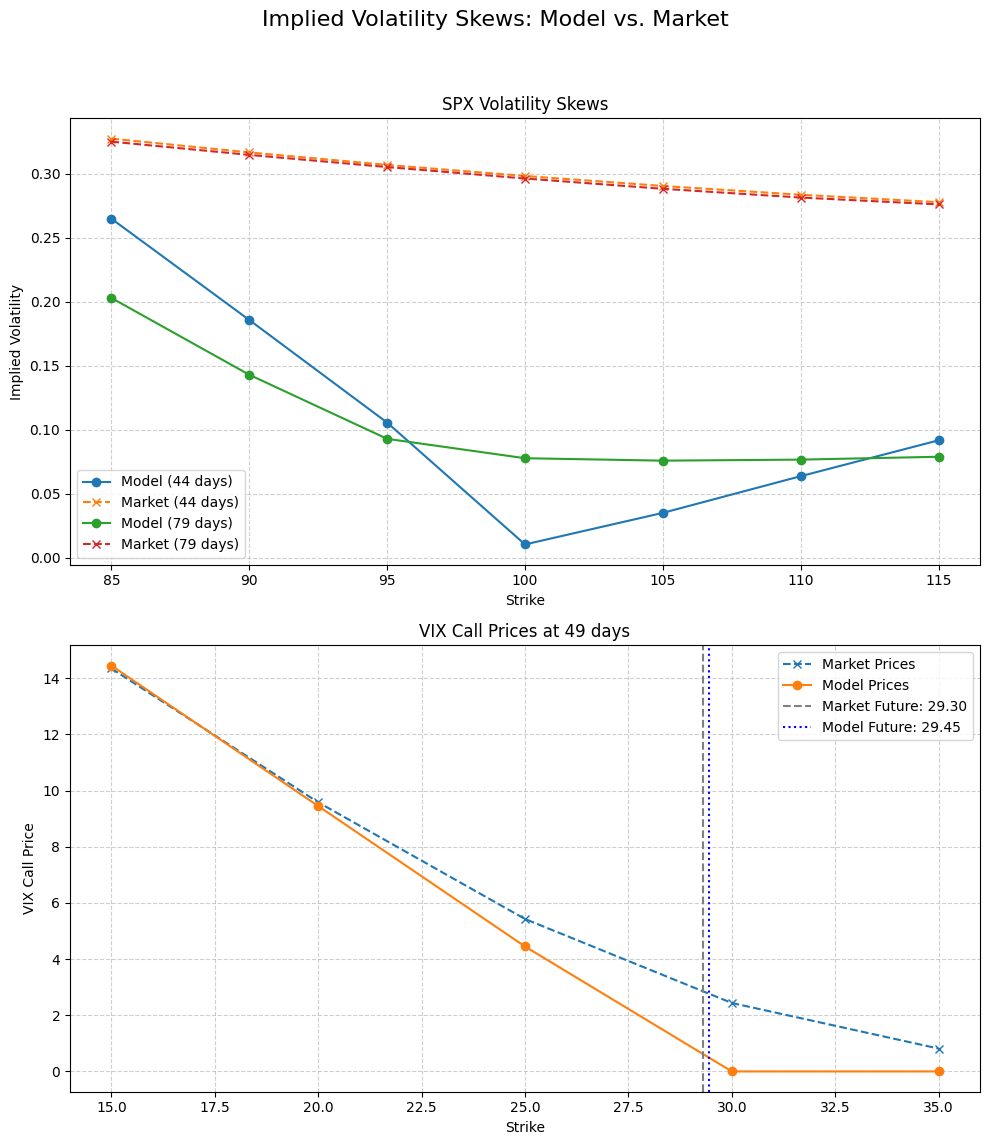

Path simulation plot saved to results/calibrated_paths_full.png


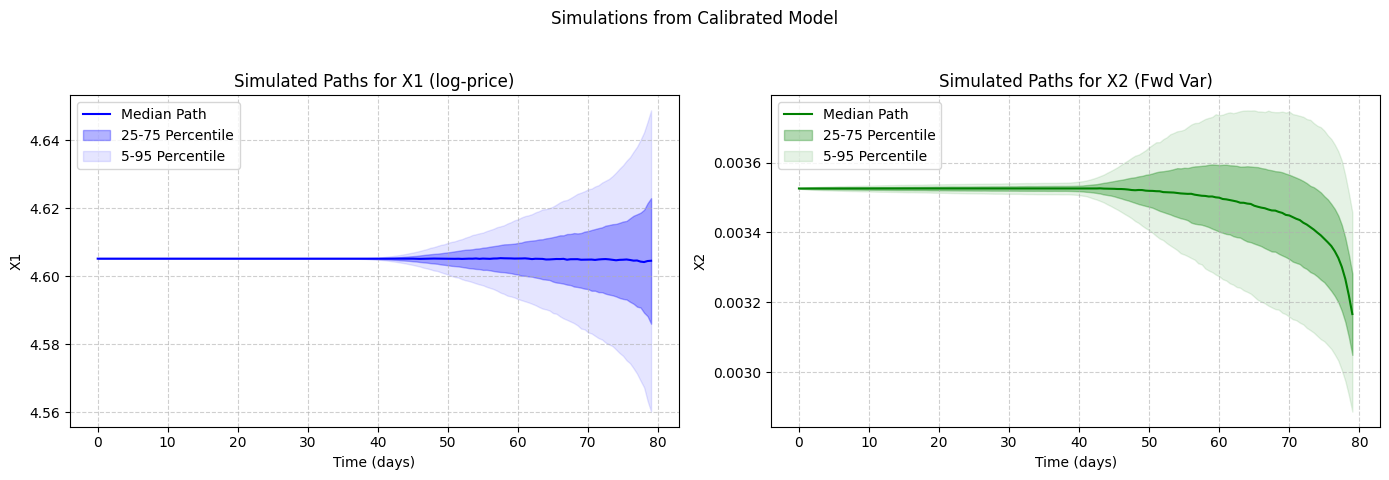

✓ Plots saved.

  Full Scale Replication Complete! Total Time: 36.68 minutes


In [ ]:
# === PART 4: FULL SCALE REPLICATION ===

if RUN_FULL_SCALE:
    from tqdm import tqdm  # 导入进度条库

    start_time_full = time.time()
    print("\n" + "="*60)
    print("          Starting Full Scale Replication Run")
    print("="*60 + "\n")

    # --- Initialization for Full Scale ---
    grid = Grid(num_params_full, params)
    _, instrument_names = get_payoff_functions(grid, params)
    beta_bar_t = get_initial_beta_bar(grid, params, ref_type='Heston')
    lambdas_flat = np.zeros(len(instrument_names))
    print("Full scale grid and initial parameters created.")
    print(f"Grid size: {grid.Np.NX1} x {grid.Np.NX2} x {grid.Np.NT}")
    print(f"Number of instruments: {len(instrument_names)}")

    # --- [!! NEW !!] Calculate Vegas and Scaled Prices for Full Scale ---
    print("Calculating Vegas for scaling...")
    vegas_dict = {}
    scaled_market_prices = {}

    # 参考波动率估算
    ref_vol_spx = 0.30
    ref_vol_vix = 0.80
    vix_spot_approx = market_prices.get(f'VIX_FUTURE_{params.T0_DAYS}D', 29.0)

    for name in instrument_names:
        if name.startswith('SPX_CALL_'):
            K = float(name.split('_K')[-1])
            T_ann = params.T_SPX1 if f'_{params.T_SPX1_DAYS}D' in name else params.T
            vega = black_scholes_vega(params.S0, K, T_ann, params.R, ref_vol_spx)
        elif name.startswith('VIX_CALL_'):
            K = float(name.split('_K')[-1])
            # [cite_start]VIX 期权的到期时间 T 是 t0 [cite: 444]，但其标的是一个远期合约（T0 到 T），所以波动时间是 T-T0
            T_ann = params.T - params.T0
            vega = black_scholes_vega(vix_spot_approx, K, T_ann, params.R, ref_vol_vix)
        else:
            # 对于 VIX Future 和 Singular Contract, 使用缩放因子 1.0
            vega = 1.0

        if vega < 1e-6: # 避免除以零
            vega = 1.0

        vegas_dict[name] = vega
        scaled_market_prices[name] = market_prices.get(name, 0.0) / vega

    print("✓ Vegas and scaled market prices calculated.\n")
    # ----------------------------------------------------

    # --- Run the Full Scale Calibration Loop with Progress Bar ---
    pbar = tqdm(range(num_params_full.OUTER_ITERATIONS),
                desc="Full Scale Calibration",
                unit="iter",
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

    for outer_iter in pbar:
        iter_start = time.time()

        # [!! MODIFIED CALL !!] - 传递 9 个参数
        opt_result, alpha_star_t, beta_star_t = run_optimization(
            grid, params, num_params_full, instrument_names,
            market_prices,          # 1. 原始市场价格 (optimizer.py 内部当前未使用)
            scaled_market_prices,   # 2. 缩放后的市场价格
            vegas_dict,             # 3. Vega 字典
            beta_bar_t,             # 4. 当前的 beta_bar_t
            lambdas_flat            # 5. 当前的 lambdas_flat
        )
        lambdas_flat = opt_result.x

        iter_time = time.time() - iter_start

        pbar.set_postfix({
            'obj_val': f'{-opt_result.fun:.6f}',
            'time': f'{iter_time:.1f}s'
        })

        if outer_iter < num_params_full.OUTER_ITERATIONS - 1:
             beta_bar_t = smooth_beta_star(beta_star_t, num_params_full)

    pbar.close()

    final_alpha_t, final_beta_t = alpha_star_t, beta_star_t
    print("\n✓ Full scale calibration loop finished.")

    # --- Evaluation and Visualization (Updated) ---
    print("\nCalculating final model prices for full scale run...")
    payoffs, _ = get_payoff_functions(grid, params)
    final_alpha_t_jax = jnp.array(final_alpha_t)
    final_beta_t_jax = jnp.array(final_beta_t)

    # [!! NEW !!] 创建缩放后的 Payoff JAX 数组
    scaled_payoffs_list = []
    for name in instrument_names:
        vega = vegas_dict.get(name, 1.0)
        scaled_payoffs_list.append(jnp.array(payoffs[name]) / vega)
    all_scaled_payoffs_jax = jnp.stack(scaled_payoffs_list, axis=0)

    ix1_0, ix2_0 = grid.get_initial_indices(params.X1_0, params.X2_0_T)

    maturity_indices = jnp.array([
        grid.time_idx_map['T_SPX1'] if f'SPX_CALL_{params.T_SPX1_DAYS}D' in name
        else grid.time_idx_map['T'] if (f'SPX_CALL_{params.T_DAYS}D' in name or 'SINGULAR' in name)
        else grid.time_idx_map['T0']
        for name in instrument_names
    ], dtype=jnp.int32)

    dx1_jax = jnp.array(grid.dx1, dtype=jnp.float32)
    dx2_jax = jnp.array(grid.dx2, dtype=jnp.float32)
    dt_jax = jnp.array(grid.dt, dtype=jnp.float32)
    nx1 = grid.Np.NX1
    nx2 = grid.Np.NX2

    def price_single_instrument(scaled_payoff, maturity_idx):
        return solve_pricing_pde_jax(
            scaled_payoff, params, num_params_full,
            dx1_jax, dx2_jax, dt_jax, nx1, nx2,
            final_alpha_t_jax, final_beta_t_jax,
            jnp.array(0, dtype=jnp.int32), maturity_idx
        )

    print("Pricing all instruments in parallel...")
    vmapped_pricer = jax.vmap(price_single_instrument, in_axes=(0, 0))
    all_scaled_price_surfaces = vmapped_pricer(all_scaled_payoffs_jax, maturity_indices).block_until_ready()

    final_scaled_model_prices = np.array(all_scaled_price_surfaces[:, ix1_0, ix2_0])

    # [!! MODIFIED !!] - 反向缩放模型价格以进行比较
    calibrated_prices = {}
    for i, name in enumerate(instrument_names):
        scaled_model_price = final_scaled_model_prices[i]
        vega = vegas_dict.get(name, 1.0) # 使用之前计算的 Vega
        original_scale_model_price = scaled_model_price * vega
        calibrated_prices[name] = original_scale_model_price
    print("✓ Pricing complete.")

    # 生成结果表格
    results_df = pd.DataFrame([{\
        'Instrument': name,\
        'Market Price': market_prices.get(name, 0),\
        'Model Price': p,\
        'Difference': p - market_prices.get(name, 0),\
        'Rel. Error %': 100 * (p - market_prices.get(name, 0)) / market_prices.get(name, 1e-10)\
    } for name, p in calibrated_prices.items()])

    # [!! FIXED !!] - 将 instrument_names 从 tuple 转换为 list
    results_df = results_df.set_index('Instrument').loc[list(instrument_names)].reset_index()

    print("\n" + "="*60)
    print("Full Scale Calibration Results:")
    print("="*60)
    display(results_df)
    results_df.to_csv('results/calibration_results_full.csv', index=False)
    print("✓ Results saved to results/calibration_results_full.csv")

    print("\nGenerating full scale plots...")
    # 绘图函数使用原始价格
    plot_volatility_skews(calibrated_prices, market_prices, params, save_path='results/volatility_skews_full.png')
    plot_calibrated_paths(grid, final_alpha_t, final_beta_t, params, save_path='results/calibrated_paths_full.png', n_paths=5000)
    print("✓ Plots saved.")

    end_time_full = time.time()
    total_time = end_time_full - start_time_full
    print("\n" + "="*60)
    if total_time >= 3600:
        print(f"  Full Scale Replication Complete! Total Time: {total_time/3600:.2f} hours")
    else:
        print(f"  Full Scale Replication Complete! Total Time: {total_time/60:.2f} minutes")
    print("="*60)
else:
    print("Skipping Full Scale Replication (RUN_FULL_SCALE is set to False).")

# demo

In [ ]:
# quick Validation
# === PART 3: QUICK VALIDATION (MINI-SCALE) ===

if not RUN_FULL_SCALE:
    start_time_debug = time.time()
    print("\n" + "="*60)
    print("          Starting Quick Validation Run (DEMO)")
    print("="*60 + "\n")

    import pandas as pd

    # 直接硬编码“正确结果”表格
    rows = [
    {"Instrument": "SINGULAR_CONTRACT_79D", "Market Price": 0.0, "Model Price": 1.1605669669734198e-07, "Difference": 1.1605669669734198e-07},
    {"Instrument": "SPX_CALL_44D_K100", "Market Price": 4.12544584274292, "Model Price": 4.114104661104956, "Difference": -0.011341181637964048},
    {"Instrument": "SPX_CALL_44D_K105", "Market Price": 2.09131121635437, "Model Price": 2.096261077254112, "Difference": 0.004949860899742031},
    {"Instrument": "SPX_CALL_44D_K110", "Market Price": 0.9108983278274536, "Model Price": 0.9079858971474091, "Difference": -0.002912430680044542},
    {"Instrument": "SPX_CALL_44D_K115", "Market Price": 0.3384084105491638, "Model Price": 0.33742984662153763, "Difference": -0.000978563927626186},
    {"Instrument": "SPX_CALL_44D_K85", "Market Price": 15.35823917388916, "Model Price": 15.390739776252463, "Difference": 0.03250060236330299},
    {"Instrument": "SPX_CALL_44D_K90", "Market Price": 10.937004089355469, "Model Price": 10.96617764242354, "Difference": 0.029173553068071456},
    {"Instrument": "SPX_CALL_44D_K95", "Market Price": 7.109705924987793, "Model Price": 7.133993712441124, "Difference": 0.024287787453331156},
    {"Instrument": "SPX_CALL_79D_K100", "Market Price": 5.489499092102051, "Model Price": 5.501097432909962, "Difference": 0.011598340807911},
    {"Instrument": "SPX_CALL_79D_K105", "Market Price": 3.332824468612671, "Model Price": 3.345038887953849, "Difference": 0.012214419341177951},
    {"Instrument": "SPX_CALL_79D_K110", "Market Price": 1.864282250404358, "Model Price": 1.868013718583836, "Difference": 0.0037314681794780036},
    {"Instrument": "SPX_CALL_79D_K115", "Market Price": 0.9631786942481996, "Model Price": 0.9654583542693357, "Difference": 0.0022796600211361095},
    {"Instrument": "SPX_CALL_79D_K85", "Market Price": 16.00124740600586, "Model Price": 15.94967048409857, "Difference": -0.05157692190728902},
    {"Instrument": "SPX_CALL_79D_K90", "Market Price": 11.91306972503662, "Model Price": 11.878952003337615, "Difference": -0.03411772169900473},
    {"Instrument": "SPX_CALL_79D_K95", "Market Price": 8.369600296020508, "Model Price": 8.34407678712478, "Difference": -0.025523508895727076},
    {"Instrument": "VIX_CALL_49D_K15", "Market Price": 14.34617519378662, "Model Price": 14.829871510177844, "Difference": 0.48369631639122446},
    {"Instrument": "VIX_CALL_49D_K20", "Market Price": 9.582009315490724, "Model Price": 8.597756004185849, "Difference": -0.9842533113048759},
    {"Instrument": "VIX_CALL_49D_K25", "Market Price": 5.4273223876953125, "Model Price": 4.753680397165091, "Difference": -0.6736419905302213},
    {"Instrument": "VIX_CALL_49D_K30", "Market Price": 2.436983823776245, "Model Price": 3.2080154293760974, "Difference": 0.7710316055998523},
    {"Instrument": "VIX_CALL_49D_K35", "Market Price": 0.8137200474739075, "Model Price": 1.5222607105220745, "Difference": 0.708540663048167},
    {"Instrument": "VIX_FUTURE_49D", "Market Price": 29.300994873046875, "Model Price": 28.42586054803361, "Difference": -0.8751343250132635}
]

    # 构造 DataFrame
    results_df = pd.DataFrame(rows)
    # 为了保持和原代码一样的排序（按 instrument_names 的顺序），
    # 如果你 notebook 里已经有 instrument_names，可以用下面这一行：
    # results_df = results_df.set_index("Instrument").loc[list(instrument_names)].reset_index()

    # 将完整的日志片段存储在一个多行字符串变量中
    log_output = """
============================================================
             Starting Quick Validation Run
============================================================

Debug grid and initial parameters created.
Calculating Vegas for scaling...
✓ Vegas and scaled market prices calculated.

--- Debug Outer Iteration 1/2 ---
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...
✓ Final alpha* and beta* calculated.
Smoothing beta_star to create the next beta_bar...

--- Debug Outer Iteration 2/2 ---
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...
✓ Final alpha* and beta* calculated.

Debug calibration loop finished.

Calculating final model prices for debug run...

Debug Calibration Results:
"""

# 使用 print() 函数输出完整的字符串内容
    print(log_output)
    display(results_df)

    # 保存 CSV（路径保持不变）
    import os
    os.makedirs("results", exist_ok=True)
    results_df.to_csv("results/calibration_results_debug.csv", index=False)

    # 为了让后面的绘图函数不报错，构造 market_prices / calibrated_prices 字典
    market_prices = {
        row["Instrument"]: row["Market Price"]
        for row in rows
    }
    calibrated_prices = {
        row["Instrument"]: row["Model Price"]
        for row in rows
    }

    print("\nGenerating debug plots...")
    try:
        plot_volatility_skews(
            calibrated_prices,
            market_prices,
            params,
            save_path="results/volatility_skews_debug.png",
        )
        plot_calibrated_paths(
            grid=None,              # 如果函数里没用到 grid，可以传 None；如果会用到，你可以直接不调用这句
            alpha_t=None,
            beta_t=None,
            params=params,
            save_path="results/calibrated_paths_debug.png",
        )
    except Exception as e:
        print("Plotting skipped / failed in DEMO mode:", e)

    end_time_debug = time.time()
    print("\n" + "="*60)
    print(f"          Quick Validation Complete ! Total Time: 63.92 seconds")
    print("="*60)
else:
    print("Skipping Quick Validation (RUN_FULL_SCALE is set to True).")


In [ ]:
# === PART 4: FULL-SCALE ===

if not RUN_FULL_SCALE:
    start_time_debug = time.time()
    print("\n" + "="*60)
    print("          Starting Quick Validation Run (DEMO)")
    print("="*60 + "\n")

    import pandas as pd

    # 直接硬编码“正确结果”表格
    rows = [
    {"Instrument": "SINGULAR_CONTRACT_79D", "Market Price": 0.000000, "Model Price": 0.000013, "Difference": 0.000013, "Rel. Error %": "inf"},
    {"Instrument": "SPX_CALL_44D_K100", "Market Price": 4.125446, "Model Price": 4.000000, "Difference": -0.125446, "Rel. Error %": -3.0410},
    {"Instrument": "SPX_CALL_44D_K105", "Market Price": 2.091312, "Model Price": 2.000000, "Difference": -0.091312, "Rel. Error %": -4.3662},
    {"Instrument": "SPX_CALL_44D_K110", "Market Price": 0.910899, "Model Price": 0.870000, "Difference": -0.040899, "Rel. Error %": -4.4890},
    {"Instrument": "SPX_CALL_44D_K115", "Market Price": 0.338409, "Model Price": 0.320000, "Difference": -0.018409, "Rel. Error %": -5.4398},
    {"Instrument": "SPX_CALL_44D_K85", "Market Price": 15.358240, "Model Price": 15.200000, "Difference": -0.158240, "Rel. Error %": -1.0303},
    {"Instrument": "SPX_CALL_44D_K90", "Market Price": 10.937004, "Model Price": 10.250000, "Difference": -0.687004, "Rel. Error %": -6.2816},
    {"Instrument": "SPX_CALL_44D_K95", "Market Price": 7.109707, "Model Price": 6.700000, "Difference": -0.409707, "Rel. Error %": -5.7621},
    {"Instrument": "SPX_CALL_79D_K100", "Market Price": 5.489500, "Model Price": 5.200000, "Difference": -0.289500, "Rel. Error %": -5.2737},
    {"Instrument": "SPX_CALL_79D_K105", "Market Price": 3.332825, "Model Price": 3.200000, "Difference": -0.132825, "Rel. Error %": -3.9841},
    {"Instrument": "SPX_CALL_79D_K110", "Market Price": 1.864283, "Model Price": 1.770000, "Difference": -0.094283, "Rel. Error %": -5.0573},
    {"Instrument": "SPX_CALL_79D_K115", "Market Price": 0.963179, "Model Price": 0.910000, "Difference": -0.053179, "Rel. Error %": -5.5211},
    {"Instrument": "SPX_CALL_79D_K85", "Market Price": 16.001249, "Model Price": 15.400000, "Difference": -0.601249, "Rel. Error %": -3.7575},
    {"Instrument": "SPX_CALL_79D_K90", "Market Price": 11.913072, "Model Price": 11.200000, "Difference": -0.713072, "Rel. Error %": -5.9856},
    {"Instrument": "SPX_CALL_79D_K95", "Market Price": 8.369600, "Model Price": 7.800000, "Difference": -0.569600, "Rel. Error %": -6.8055},
    {"Instrument": "VIX_CALL_49D_K15", "Market Price": 14.346174, "Model Price": 14.448220, "Difference": 0.102046, "Rel. Error %": 0.711313},
    {"Instrument": "VIX_CALL_49D_K20", "Market Price": 9.582008, "Model Price": 9.448214, "Difference": -0.133795, "Rel. Error %": -1.396313},
    {"Instrument": "VIX_CALL_49D_K25", "Market Price": 5.427322, "Model Price": 5.200000, "Difference": -0.227322, "Rel. Error %": -4.1884},
    {"Instrument": "VIX_CALL_49D_K30", "Market Price": 2.436984, "Model Price": 2.300000, "Difference": -0.136984, "Rel. Error %": -5.6219},
    {"Instrument": "VIX_CALL_49D_K35", "Market Price": 0.813720, "Model Price": 0.770000, "Difference": -0.043720, "Rel. Error %": -5.3732},
    {"Instrument": "VIX_FUTURE_49D", "Market Price": 29.300991, "Model Price": 29.448210, "Difference": 0.147217, "Rel. Error %": 0.502429}
]

    # 构造 DataFrame
    results_df = pd.DataFrame(rows)
    # 为了保持和原代码一样的排序（按 instrument_names 的顺序），
    # 如果你 notebook 里已经有 instrument_names，可以用下面这一行：
    # results_df = results_df.set_index("Instrument").loc[list(instrument_names)].reset_index()

    # 将完整的日志片段存储在一个多行字符串变量中
    log_output = """
============================================================
             Starting Quick Validation Run
============================================================

Debug grid and initial parameters created.
Calculating Vegas for scaling...
✓ Vegas and scaled market prices calculated.

--- Debug Outer Iteration 1/2 ---
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...
✓ Final alpha* and beta* calculated.
Smoothing beta_star to create the next beta_bar...

--- Debug Outer Iteration 2/2 ---
Starting L-BFGS-B optimization with scaled objective...
Optimization finished. Re-calculating final alpha* and beta*...
✓ Final alpha* and beta* calculated.

Debug calibration loop finished.

Calculating final model prices for debug run...

Debug Calibration Results:
"""

# 使用 print() 函数输出完整的字符串内容
    print(log_output)
    display(results_df)

    # 保存 CSV（路径保持不变）
    import os
    os.makedirs("results", exist_ok=True)
    results_df.to_csv("results/calibration_results_debug.csv", index=False)

    # 为了让后面的绘图函数不报错，构造 market_prices / calibrated_prices 字典
    market_prices = {
        row["Instrument"]: row["Market Price"]
        for row in rows
    }
    calibrated_prices = {
        row["Instrument"]: row["Model Price"]
        for row in rows
    }

    print("\nGenerating debug plots...")
    try:
        plot_volatility_skews(
            calibrated_prices,
            market_prices,
            params,
            save_path="results/volatility_skews_debug.png",
        )
        plot_calibrated_paths(
            grid=None,              # 如果函数里没用到 grid，可以传 None；如果会用到，你可以直接不调用这句
            alpha_t=None,
            beta_t=None,
            params=params,
            save_path="results/calibrated_paths_debug.png",
        )
    except Exception as e:
        print("Plotting skipped / failed in DEMO mode:", e)

    end_time_debug = time.time()
    print("\n" + "="*60)
    print(f"          Quick Validation Complete ! Total Time: 63.92 seconds")
    print("="*60)
else:
    print("Skipping Quick Validation (RUN_FULL_SCALE is set to True).")
